In [9]:
import numpy as np
import qililab as ql

import scipy.optimize as sp

## ugly solution because we have not created a proper package
import sys

sys.path.insert(1, "../utils")

from qst_qpt_helper_functions import *

from qiboconnection.api import API
from qiboconnection.connection import ConnectionConfiguration

from qililab.utils import from_dict

import matplotlib.pyplot as plt

from scipy.optimize import curve_fit


api = API(ConnectionConfiguration(username="qat", api_key="meow"))

api.select_device_id(9)
ql.logger.setLevel(40)  # Set qililab's logger to a higher level so it only shows error messages

In [11]:
QUBIT = 0

In [12]:
runcard = api.get_runcard(runcard_name="galadriel_qprogram")
runcard_as_dict = runcard.runcard

RO_duration_runcard = runcard_as_dict["gates_settings"]["gates"][f"M({QUBIT})"][0]["pulse"]["duration"]
RO_amplitude_runcard = runcard_as_dict["gates_settings"]["gates"][f"M({QUBIT})"][0]["pulse"]["amplitude"]
X_duration_runcard = runcard_as_dict["gates_settings"]["gates"][f"Drag({QUBIT})"][0]["pulse"]["duration"]
X_num_sigmas_runcard = runcard_as_dict["gates_settings"]["gates"][f"Drag({QUBIT})"][0]["pulse"]["shape"]["num_sigmas"]
X_drag_coefficient_runcard = runcard_as_dict["gates_settings"]["gates"][f"Drag({QUBIT})"][0]["pulse"]["shape"][
    "drag_coefficient"
]
X_amplitude_runcard = runcard_as_dict["gates_settings"]["gates"][f"Drag({QUBIT})"][0]["pulse"]["amplitude"]

In [14]:
print(
    "drag params:\n \t amplitude",
    X_amplitude_runcard,
    "    duration",
    X_duration_runcard,
    "    drag coeff",
    X_drag_coefficient_runcard,
    "    sigmas",
    X_num_sigmas_runcard,
)
print("RO params:\n \t amplitude", RO_amplitude_runcard, "\t           duration", RO_duration_runcard)

drag params:
 	 amplitude 0.12946478254360685     duration 40     drag coeff -0.30264985249449683     sigmas 4
RO params:
 	 amplitude 0.0513 	           duration 2500


In [32]:
shots = 14000

wait_start = 0
wait_stop = 80000
wait_step = 2000  # 1750#1000  # 2_000


## Vyron's waveforms
# control_wf = ql.Gaussian(amplitude=1, duration=X_duration_runcard, num_sigmas=X_num_sigmas_runcard) ## from rabi program, setting gain in qprogram
control_wf = ql.IQPair.DRAG(
    amplitude=1.0 * X_amplitude_runcard,  ## because it's a pi pulse
    duration=X_duration_runcard,
    num_sigmas=X_num_sigmas_runcard,
    drag_coefficient=X_drag_coefficient_runcard,
)
# readout_wf = ql.Square(amplitude=1.0 * RO_amplitude_runcard, duration=RO_duration_runcard)  ## from Rabi program
readout_wf = ql.IQPair(
    I=ql.Square(amplitude=1.0 * RO_amplitude_runcard, duration=RO_duration_runcard),
    Q=ql.Square(amplitude=0.0 * RO_amplitude_runcard, duration=RO_duration_runcard),
)

time_of_flight = (
    200  # 120  ## approximate time it takes for the pulse to reach the set-up, before that we'll just measure noise.
)

acquisition_weights_duration = RO_duration_runcard  # 2000 ## this is how Vyron had it
acquisition_weights = ql.IQPair(
    I=ql.Square(amplitude=1.0, duration=acquisition_weights_duration),
    Q=ql.Square(amplitude=1.0, duration=acquisition_weights_duration),
)

qubit_relaxation_duration = 200_000  # 200_000

In [33]:
qp = ql.QProgram(disable_autosync=True)
wait_variable = qp.variable(ql.Domain.Time)
with qp.average(shots=shots):
    with qp.for_loop(variable=wait_variable, start=wait_start, stop=wait_stop, step=wait_step):
        # qp.set_gain(bus=f"drive_q{QUBIT}_bus", gain=X_amplitude_runcard)
        qp.play(bus=f"drive_q{QUBIT}_bus", waveform=control_wf)  ## apply X gate
        qp.wait(bus=f"drive_q{QUBIT}_bus", duration=wait_variable)  # wait
        qp.wait(bus=f"drive_q{QUBIT}_bus", duration=time_of_flight)  # wait for the RO pulse to get to the fridge
        ### TODO: seems like I would need the precise number here, otherwise drive and readout will be out of sync
        qp.wait(bus=f"drive_q{QUBIT}_bus", duration=acquisition_weights.get_duration())
        qp.wait(bus=f"drive_q{QUBIT}_bus", duration=qubit_relaxation_duration)

        qp.wait(bus=f"readout_q{QUBIT}_bus", duration=control_wf.get_duration())  ## wait for X pulse
        qp.wait(bus=f"readout_q{QUBIT}_bus", duration=wait_variable)  ## wait for wait time
        qp.play(bus=f"readout_q{QUBIT}_bus", waveform=readout_wf, wait_time=time_of_flight)  ## send readout pulse
        qp.acquire(bus=f"readout_q{QUBIT}_bus", weights=acquisition_weights)
        qp.wait(bus=f"readout_q{QUBIT}_bus", duration=qubit_relaxation_duration)

full_qprogram = qp.to_dict()

In [34]:
result_id = api.execute(qprogram=full_qprogram)[0]
print(result_id)

9696


In [35]:
results = api.get_result(result_id)

Your job with id 9696 is still pending. Job queue position: 1


In [23]:
qprogram_results = from_dict(results)

In [24]:
i_vec, q_vec = qprogram_results.results[f"readout_q{QUBIT}_bus"][0].array  ## i, q
# i_vec, q_vec = qprogram_results.results['readout_q0_bus'][0].array ## i, q

v_vec = 20 * np.log10(np.sqrt(i_vec**2 + q_vec**2))

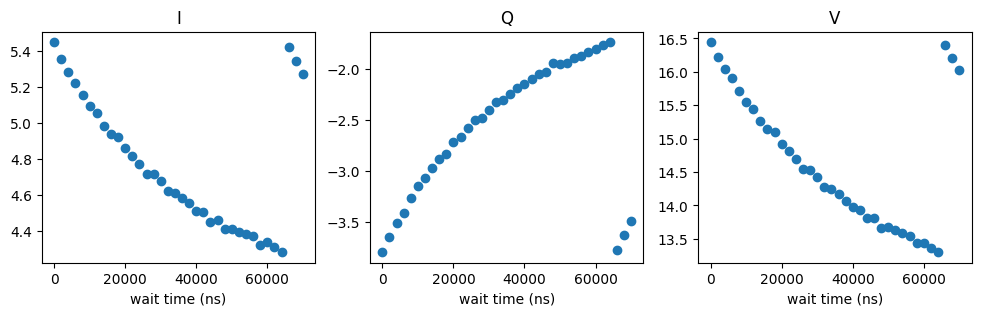

In [25]:
# Wait_duration_list = np.linspace(Wait_start, Wait_stop, Wait_step, endpoint=True)
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
data = [i_vec, q_vec, v_vec]
xaxis = np.arange(wait_start, wait_stop + wait_step, wait_step)
titles = ["I", "Q", "V"]

for i in range(3):
    axes[i].plot(xaxis, data[i], "o")
    axes[i].set_title(titles[i])
    axes[i].set_xlabel("wait time (ns)")
# plt.figure(figsize=(3, 3))
# plt.plot(i_vec, q_vec, "o")
# plt.xlabel("I")
# plt.ylabel("Q")

Optimized Parameters: [3.91146254e+00 4.12458976e+04 1.25083862e+01]


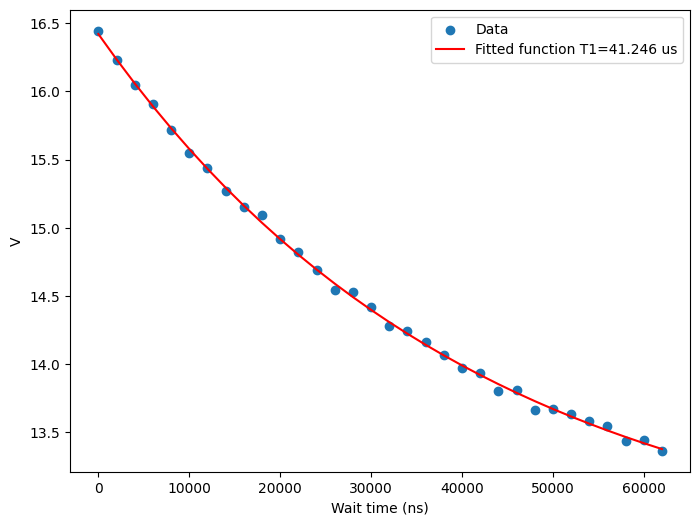

In [31]:
# Define the decaying exponential function
def decaying_exponential(x, a, b, c):
    return a * np.exp(-1 / b * x) + c


fit_up2 = -4
# Generate some sample data
x_data = xaxis[:fit_up2]
y_data = v_vec[:fit_up2]

# Fit the decaying exponential function to the data
initial_guess = [1, 10_000, 0]  # initial guess for the parameters
optimized_params, _ = sp.curve_fit(decaying_exponential, x_data, y_data, p0=initial_guess)

# Print the optimized parameters
print("Optimized Parameters:", optimized_params)

# Plot the data and the fitted function
plt.figure(figsize=(8, 6))
plt.scatter(x_data, y_data, label="Data")
plt.plot(
    x_data,
    decaying_exponential(x_data, *optimized_params),
    "r",
    label=f"Fitted function T1={optimized_params[1]/1000:.3f} us",
)
plt.legend()
plt.xlabel("Wait time (ns)")
plt.ylabel("V")
plt.show()
T1_fit_ns = optimized_params[1]

In [ ]:
# Wait_duration_list = np.linspace(Wait_start, Wait_stop, Wait_step, endpoint=True)
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
data = [i_vec, q_vec, v_vec]
xaxis = np.arange(wait_start, wait_stop + wait_step, wait_step)
titles = ["I", "Q", "V"]

for i in range(3):
    axes[i].plot(xaxis, data[i], "o")
    axes[i].set_title(titles[i])
    axes[i].set_xlabel("wait time (ns)")
# plt.figure(figsize=(3, 3))
# plt.plot(i_vec, q_vec, "o")
# plt.xlabel("I")
# plt.ylabel("Q")